### Importing Packages

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import TensorDataset
import torchvision.utils as vutils
from torchvision import transforms
import torchvision.datasets as dset
import matplotlib.animation as animation
from IPython.display import HTML

### Initializing GPU

In [131]:
print(f'CUDA available: {torch.cuda.is_available()}')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

CUDA available: True


In [118]:
root = 'seg_train'
dataset = dset.ImageFolder(root=root,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                           ]))

### Showing Images from Dataset

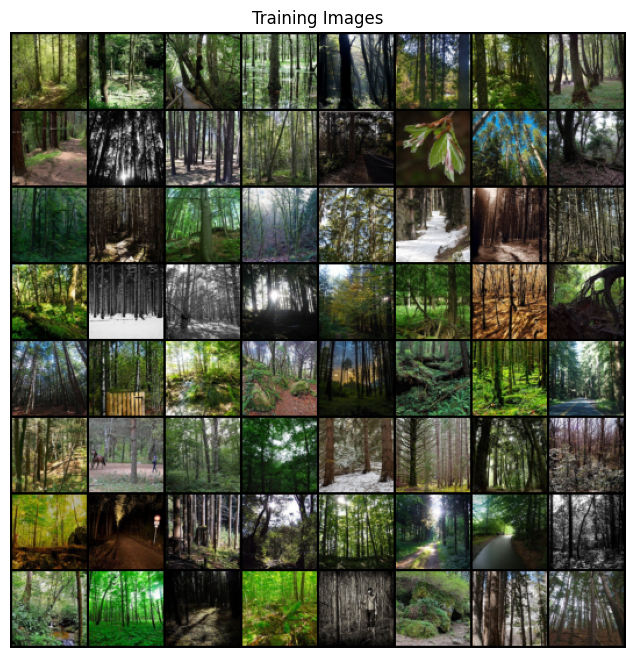

In [119]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64,
                                         shuffle=True, num_workers=2, drop_last = True)

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2).cpu(),(1,2,0)))
plt.show()

### Initializing Dataset (Just going to use buildings for now)

In [120]:
import torch
from torch.utils.data import TensorDataset


images = []
labels = []

for image, label in dataset:
    if image.shape == (3, 64, 64):
        images.append(image)
        labels.append(label)

images_tensor = torch.stack(images)  
labels_tensor = torch.tensor(labels)


tensor_dataset = TensorDataset(images_tensor, labels_tensor)


### Weight Initialization

In [121]:
def w_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, .02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, .02)
        nn.init.constant_(m.bias.data, 0)

### Designing the Generator Architecture

In [122]:
class GeneratorGAN(nn.Module):
    def __init__(self,):
        super(GeneratorGAN, self).__init__()
        self.conv1 = nn.ConvTranspose2d(100, 1024, kernel_size = 4, stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(1024)
        self.relu1 = nn.ReLU(inplace = True)

        self.conv2 = nn.ConvTranspose2d(1024, 512, kernel_size = 5, padding = 2, stride = 2, output_padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(512)
        self.relu2 = nn.ReLU(inplace = True)
        self.conv3 = nn.ConvTranspose2d(512, 256, kernel_size = 5, stride = 2, padding = 2, output_padding = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU(inplace = True)
        self.conv4 = nn.ConvTranspose2d(256, 128, kernel_size = 5, stride = 2, padding = 2, output_padding = 1, bias = False)
        self.bn4 = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU(inplace = True)
        self.conv5 = nn.ConvTranspose2d(128, 3, kernel_size = 5, stride = 2, padding = 2, output_padding = 1, bias = False)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        fc1 = self.relu1(self.bn1(self.conv1(x)))
        fc2 = self.relu2(self.bn2(self.conv2(fc1)))
        fc3 = self.relu3(self.bn3(self.conv3(fc2)))
        fc4 = self.relu4(self.bn4(self.conv4(fc3)))
        return self.tanh(self.conv5(fc4))

G = GeneratorGAN()
G = G.to(device)   
G.apply(w_init)
fixed_noise = torch.rand(64, 100, 1, 1)
fixed_noise = fixed_noise.to('cuda')
with torch.no_grad():
    output = G(fixed_noise)
output.shape

torch.Size([64, 3, 64, 64])

### Designing the Discriminator Architecture

In [123]:
class DiscriminatorGAN(nn.Module):
    def __init__(self, ):
        super(DiscriminatorGAN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 5, stride = 2, padding = 2,  bias = False)
        self.lrelu1 = nn.LeakyReLU(0.2, inplace = True)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 5, stride = 2, padding = 2, bias = False)
        self.bn2 = nn.BatchNorm2d(128)
        self.lrelu2 = nn.LeakyReLU(0.2, inplace = True)
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 5, stride = 2, padding = 2, bias = False)
        self.bn3 = nn.BatchNorm2d(256)
        self.lrelu3 = nn.LeakyReLU(0.2, inplace=True)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=5, stride = 2, padding = 2, bias = False)
        self.bn4 = nn.BatchNorm2d(512)
        self.lrelu4 = nn.LeakyReLU(0.2, inplace = True)
        self.conv5 = nn.Conv2d(512, 1, kernel_size = 4, stride = 1, bias = False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        fc1 = self.lrelu1(self.conv1(x))
        fc2 = self.lrelu2(self.bn2(self.conv2(fc1)))
        fc3 = self.lrelu3(self.bn3(self.conv3(fc2)))
        fc4 = self.lrelu4(self.bn4(self.conv4(fc3)))
        return self.sigmoid(self.conv5(fc4))
      
D = DiscriminatorGAN()
D = D.to(device)
D.apply(w_init)
sample_image = dataset[0][0]
sample_image = sample_image.unsqueeze(0)
sample_image = sample_image.to('cuda')
with torch.no_grad():
    output = D(sample_image)
output.shape

torch.Size([1, 1, 1, 1])

### Loss Functions and Optimizers

In [124]:
criterion = nn.BCELoss()
real_label = 1
fake_label = 0
lr = .0002
beta1 = 0.5

optimG = optim.Adam(G.parameters(), lr = lr, betas = (beta1, 0.999))
optimD = optim.Adam(D.parameters(), lr=lr, betas = (beta1, 0.999))

### Training

In [125]:
img_list = []
G_loss = []
D_loss = []
iters = 0
fixed_noise = fixed_noise.to('cuda')
for epoch in range(10):
    for i, data in enumerate(dataloader, 0):
        D.zero_grad()
        real_cpu = data[0].to('cuda')
        b_size = real_cpu.size(0)
        label = torch.full((b_size, ), real_label, dtype = torch.float, device = 'cuda')
        output = D(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()


        noise = torch.randn(64, 100, 1, 1, device = 'cuda')
        fake = G(noise)
        label.fill_(fake_label)
        output = D(fake.detach()).view(-1)
        errD_fake = criterion(output, label)

        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimD.step()

        G.zero_grad()
        label.fill_(real_label)

        output = D(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimG.step()

        if i % 50 == 0:
            print(f'[{epoch}/{5}][{i}/{len(dataloader)}]\tLoss_D: {errD.item()}\tLoss_G: {errG.item()}\tD(x): {D_x}\tD(G(z)): {D_G_z1} / {D_G_z2}')

        G_loss.append(errG.item())
        D_loss.append(errD.item())

        if (iters % 500 == 0) or ((epoch == 5 - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = G(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, nrow=1))  # Ensure one image per row


        iters += 1

[0/5][0/35]	Loss_D: 1.559178352355957	Loss_G: 8.874883651733398	D(x): 0.5859123468399048	D(G(z)): 0.5496141910552979 / 0.0001970881421584636
[1/5][0/35]	Loss_D: 1.3502312898635864	Loss_G: 7.228787422180176	D(x): 0.5733294486999512	D(G(z)): 0.0005701076006516814 / 0.0013339228462427855
[2/5][0/35]	Loss_D: 1.3873507976531982	Loss_G: 2.468824863433838	D(x): 0.523205041885376	D(G(z)): 0.3537825345993042 / 0.11617106199264526
[3/5][0/35]	Loss_D: 0.9680824279785156	Loss_G: 2.437765121459961	D(x): 0.6550616025924683	D(G(z)): 0.33651405572891235 / 0.14130522310733795
[4/5][0/35]	Loss_D: 0.8709166049957275	Loss_G: 1.6935282945632935	D(x): 0.7583058476448059	D(G(z)): 0.405462384223938 / 0.21460595726966858
[5/5][0/35]	Loss_D: 0.5739322900772095	Loss_G: 2.9554362297058105	D(x): 0.7696279287338257	D(G(z)): 0.2391251176595688 / 0.0718570426106453
[6/5][0/35]	Loss_D: 0.9492384791374207	Loss_G: 4.120368480682373	D(x): 0.737657904624939	D(G(z)): 0.41311538219451904 / 0.027871767058968544
[7/5][0/35]	L

### Plotting Loss over Iterations

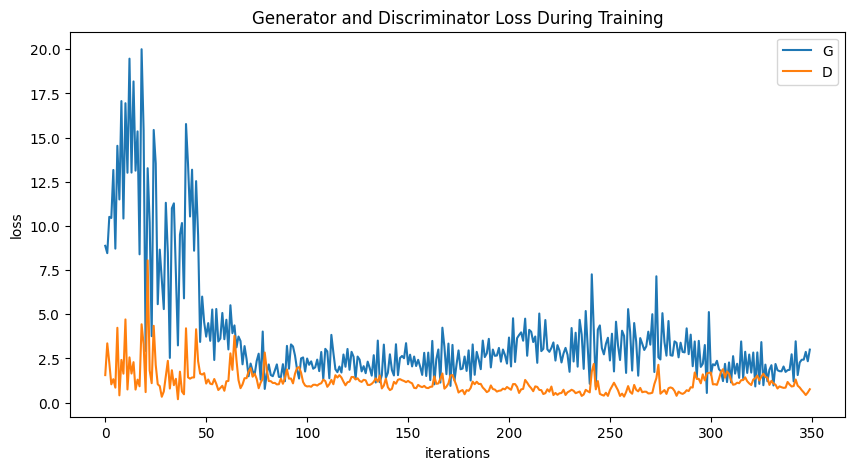

In [126]:
plt.figure(figsize = (10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_loss, label = "G")
plt.plot(D_loss, label = "D")
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend()
plt.show()

### Generating an Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


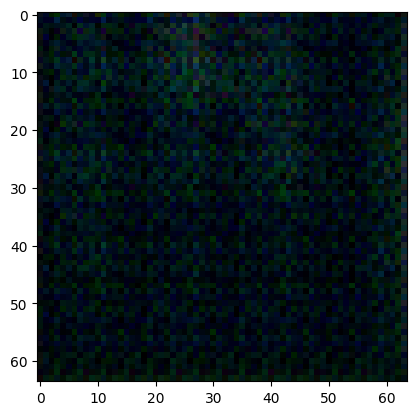

In [127]:
G.eval()
output = G(fixed_noise)
img = output[0, :, :, :]
img = img.permute(1, 2, 0)
img = img.cpu()
img = img.detach()
img = img.numpy()
plt.imshow(img)

### Showing Real vs Fake Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


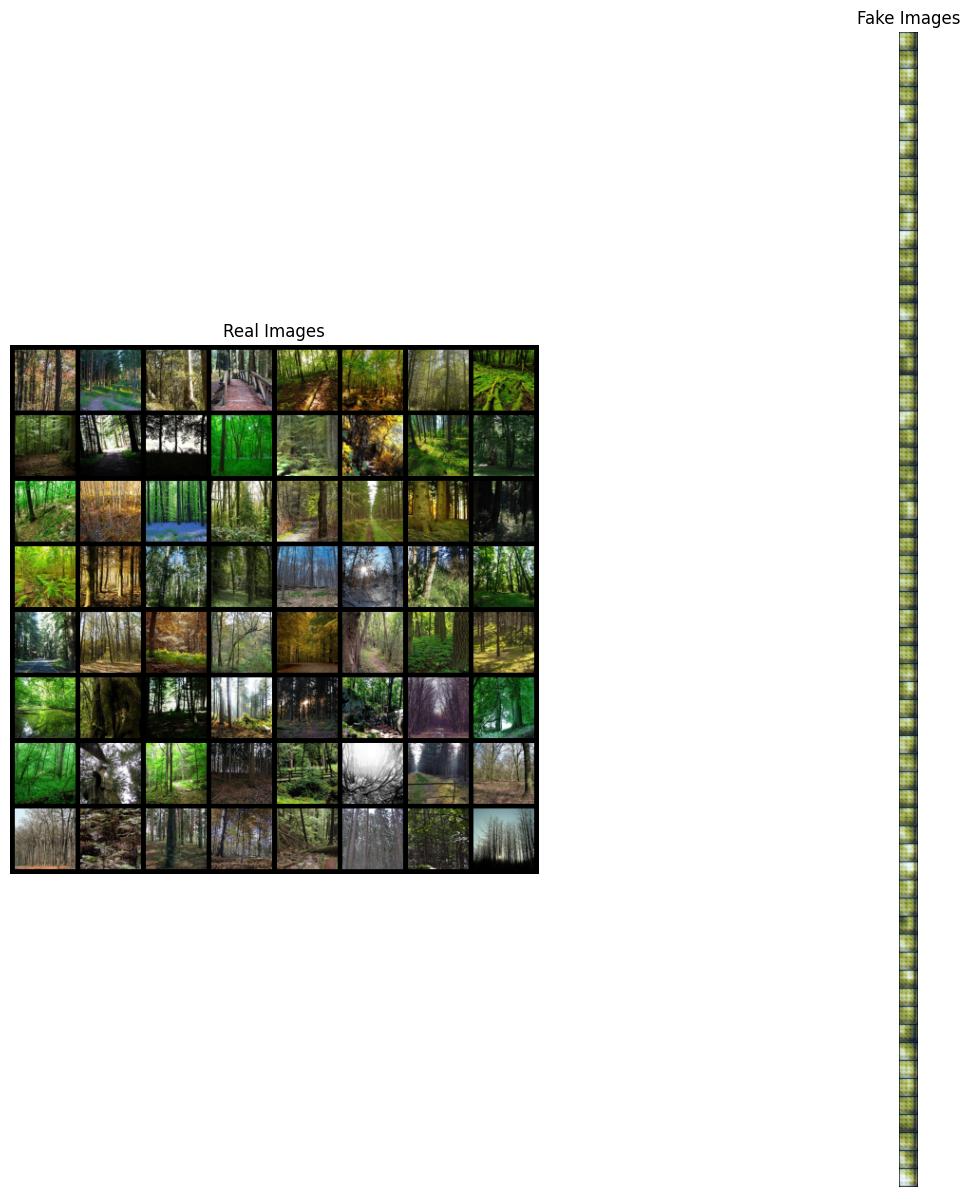

In [129]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()